# Project 4: Depth Estimation using Stereo

## Part 1: Simple stereo by matching patches

We know that there is some encoding of depth when images are captured using a stereo rig, much like human eyes.

You can try a simple experiment to see the stereo effect in action. Try seeing a scene with only your left eye. Then close your left eye and see using your right eye. Make the transition quickly. You should notice a horizontal shift in the image perceived. Can you comment on the difference in shift for different objects when you do this experiment? Is it related to the depth of the objects in some way?

In this notebook, we will generate disparity maps — maps of horizontal shifts estimated at each pixel. We will start working on a simple algorithm, which will then be evolved to give better disparity maps.

## Setup

1. Install Miniconda. It doesn’t matter whether you use Python 2 or 3 because we will create our own environment that uses 3 anyways.
2. Create a conda environment using the appropriate command. On Windows, open the installed “Conda prompt” to run the command. On MacOS and Linux, you can just use a terminal window to run the command, Modify the command based on your OS (linux, mac, or win): `conda env create -f proj4_env_<OS>.yml`
3. This should create an environment named ‘proj4’. Activate it using the Windows command, activate proj4 or the MacOS / Linux command, source activate proj4
4. Install the project package, by running `pip install -e .` inside the repo folder.
5. Run the notebook using `jupyter notebook ./proj4_code/simple_stereo.ipynb`
6. Ensure that all sanity checks are passing by running pytest inside the “unit_tests/” folder.
7. Generate the zip folder for the code portion of your submission once you’ve finished the project using `python3 zip_submission.py --uid <your_uid>` and submit to Gradescope.

## Writeup

For this project, you will answer all written questions directly within this notebook. Each section includes specific questions related to your implementation, results, and analysis.

Provide concise and well-organized explanations in the answer cells provided. Your responses should describe the logic behind your algorithm, the design decisions you made, and your observations from the results. A good writeup not only presents outputs but also discusses what they mean and why they behave as expected.

If you implement any extensions or improvements beyond the required parts, include them in the “Extra Credit” section at the end of the notebook. Ensure that all code, figures, and explanations needed for grading are included here, as this notebook will be the only file submitted to Gradescope.

## Rubric (Total: 100 pts)

- **60 pts: Code**
  - 15 pts: `generate_random_stereogram` in `utils.py`
  - 15 pts: `similarity_measures.py`
  - 30 pts: `disparity_map.py`
- **40 pts: Writeup (within notebook)**
- **−5 × n pts:** Lose 5 points for each instruction not followed for submission format or naming.

In [63]:
%pip install pillow
%pip install torch
%pip install matplotlib



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [64]:
# Import required packages and helper functions
# Make sure you've run `pip install -e .` before executing this cell

import sys
sys.path.append('..')

from proj4_code.utils import load_image, PIL_resize, generate_random_stereogram, stereo_helper_fn
from proj4_code.disparity_map import calculate_disparity_map
from proj4_code.similarity_measures import ssd_similarity_measure, sad_similarity_measure

import torch
import numpy as np
import matplotlib.pyplot as plt

from unit_tests.test_base import verify

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We will use a helper function called `stereo_helper_fn` from `utils.py` for calculating and plotting the disparity maps using the functions you will define in this notebook.

## Random dot stereogram

It was once believed that in order to perceive depth, one must either match feature points (like SIFT) between left and right images, or rely on other visual cues such as shadows.

A *random dot stereogram* eliminates all other depth cues, proving that a stereo setup alone is sufficient to infer depth.

A random dot stereogram is generated by the following steps:

1. Create the left image with random dots at each pixel (values 0 or 1).  
2. Create the right image as a copy of the left image.  
3. Select a region in the right image and shift it horizontally.  
4. Add a random pattern in the right image to fill the empty region created after the shift.

You will implement these steps in the function `generate_random_stereogram()` in `utils.py`.  
A corresponding unit test is defined in `test_utils.py`.

Please read the documentation carefully before you begin.

### Reflection Question 1:
What is the relation between disparity map and depth?  
**Answer:** Text/Equations/Drawing — whatever you feel is relevant
Disparity measures how far a 3d point shifts between two images, and depth is how far an object is from the camera, and how far it is between other objects in the image. They are inversely related, where the farther the object is, the less it will move. This can be seen when we are moving (walking/driving) and the objects closer to us move faster than the ones far away.

In [65]:
# Generate left and right images
im_left, im_right = generate_random_stereogram(im_size=(51, 51, 3))

In [66]:
# Verify correctness of your generate_random_stereogram() implementation
from unit_tests.test_utils import test_generate_random_stereogram

print('Test for random dot stereogram:', verify(test_generate_random_stereogram))

Test for random dot stereogram: "Correct"


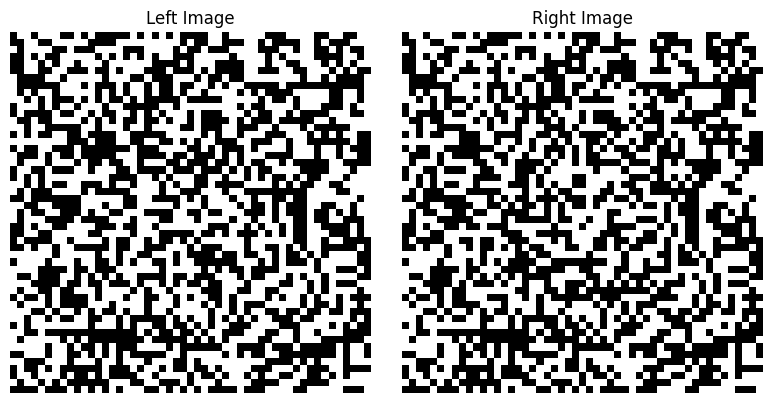

In [67]:
# Visualize the generated random dot stereogram images

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(im_left)
plt.title('Left Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(im_right)
plt.title('Right Image')
plt.axis('off')

plt.tight_layout()
plt.show()

### Reflection Question 2:
Random dot stereogram image [51×51×3]: Can you judge depth by looking at them?  
**Answer:** No you cannot, it is simply black and white shifted, there is nothing to get depth from.

## Similarity Measure

We will use similarity functions to compare patches between the left and right images.  
You will implement two types of similarity measures:

1. **Sum of Squared Differences (SSD):**  
   $SSD(A, B) = \sum_{i,j}(A_{ij} - B_{ij})^2$
2. **Sum of Absolute Differences (SAD):**  
   $SAD(A, B) = \sum_{i,j}|A_{ij} - B_{ij}$

Implement these functions in `similarity_measures.py`.  
The corresponding unit tests are defined in `test_similarity_measures.py`.

Implement the similarity function and disparity map calculation. You will need it in the next steps

### Run Similarity Measure Tests

Use the provided unit tests to verify that your implementations of the SSD and SAD functions in `similarity_measures.py` are correct.

In [68]:
# Run unit tests for the similarity measures

from unit_tests.test_similarity_measures import (
    test_ssd_similarity_measure_values,
    test_sad_similarity_measure_values,
    test_similarity_measure_size_compatibility
)

print('Testing value for SAD measure:', verify(test_sad_similarity_measure_values))
print('Testing value for SSD measure:', verify(test_ssd_similarity_measure_values))
print('Testing input size compatibility for measures:', verify(test_similarity_measure_size_compatibility))

Testing value for SAD measure: "Correct"
Testing value for SSD measure: "Correct"
Testing input size compatibility for measures: "Correct"


## Disparity Map

We are now ready to write the code for a simple algorithm for stereo matching.

<figure>
    <img src="figures/disparity_calculation_example.jpg" width="600" title="Example of a stereo algorithm" />
    <center><figcaption align="center">Example of a stereo algorithm</figcaption></center>
</figure>

These are the steps taken in this image (and will be implemented by you):

1. Pick a patch in the left image (red block), P1.
2. Place the patch in the same (x,y) coordinates in the right image (red block). As this is binocular stereo, we will need to search for P1 on the left side starting from this position. Make sure you understand this point well before proceeding further.
4. Slide the block of candidates to the left (indicated by the different pink blocks). The search area is restricted by the parameter max_search_bound in the code. The candidates will overlap.
5. We will pick the candidate patch with the minimum similarity error (green block). The horizontal shift from the red block to the green block in this image is the disparity value for the centre of P1 in the left image.

Note: the images have already been rectified and hence we can search on just a horizontal scan line.

The function works as follows:

* Input
    1. Left image
    2. Right image
    3. Similarity function
    4. Patch size
    5. Max search value
* Output
    1. Disparity map

Implement this in `disparity_map.py` (please read the documentation carefully!). The corresponding unit tests are defined in `test_disparity_map.py`.

In [69]:
from unit_tests.test_disparity_map import (
  test_disparity_deltafn_failure,
  test_disparity_deltafn_success,
  test_disparity_map_size,
  test_disparity_random_stereogram,
  test_disparity_translation_shift
)

In [70]:
# Run unit tests for disparity map implementation
print('Testing disparity map delta function (failure case):', verify(test_disparity_deltafn_failure))
print('Testing disparity map delta function (success case):', verify(test_disparity_deltafn_success))
print('Testing disparity map size', verify(test_disparity_map_size))
print('Testing random stereogram ouptut', verify(test_disparity_random_stereogram))
print('Testing disparity on translation shift', verify(test_disparity_translation_shift))

Testing disparity map delta function (failure case): "Correct"
Testing disparity map delta function (success case): "Correct"
Testing disparity map size "Correct"
Testing random stereogram ouptut "Correct"
Testing disparity on translation shift "Correct"


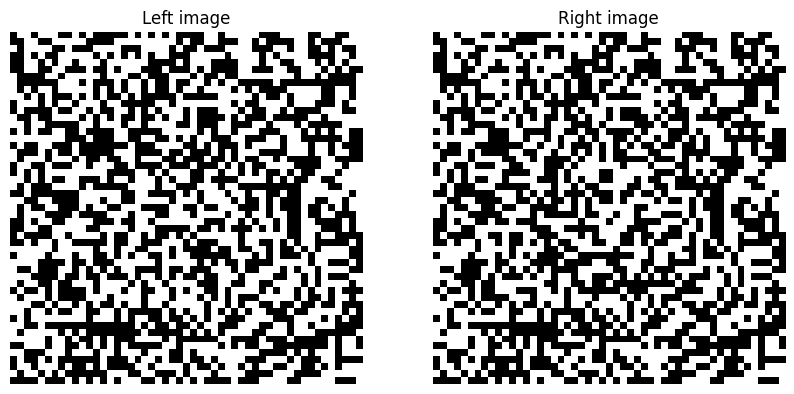

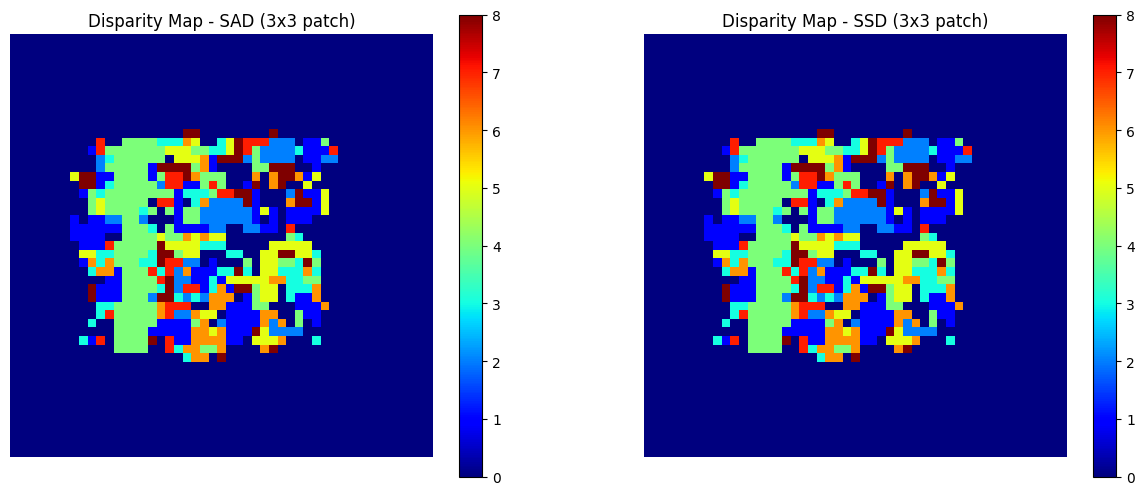

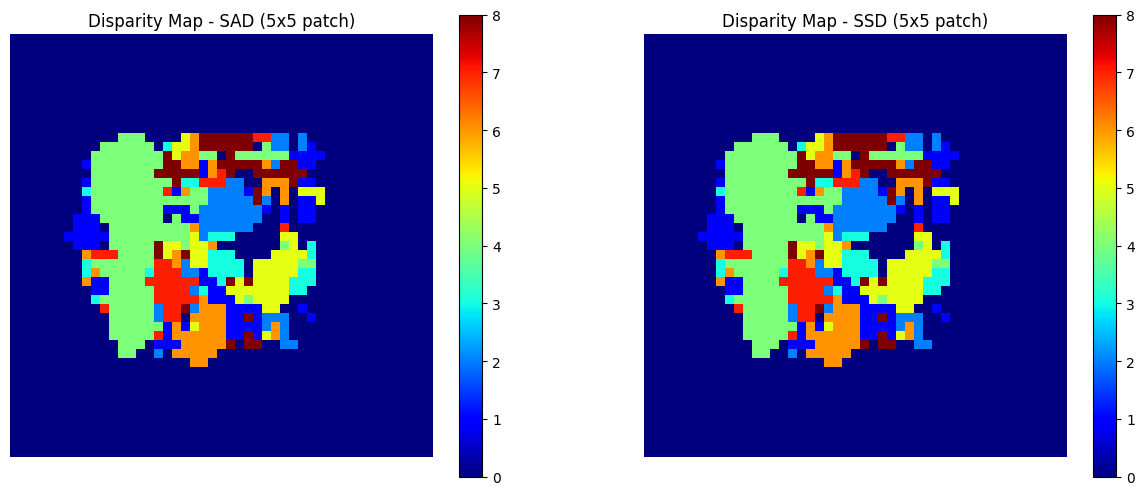

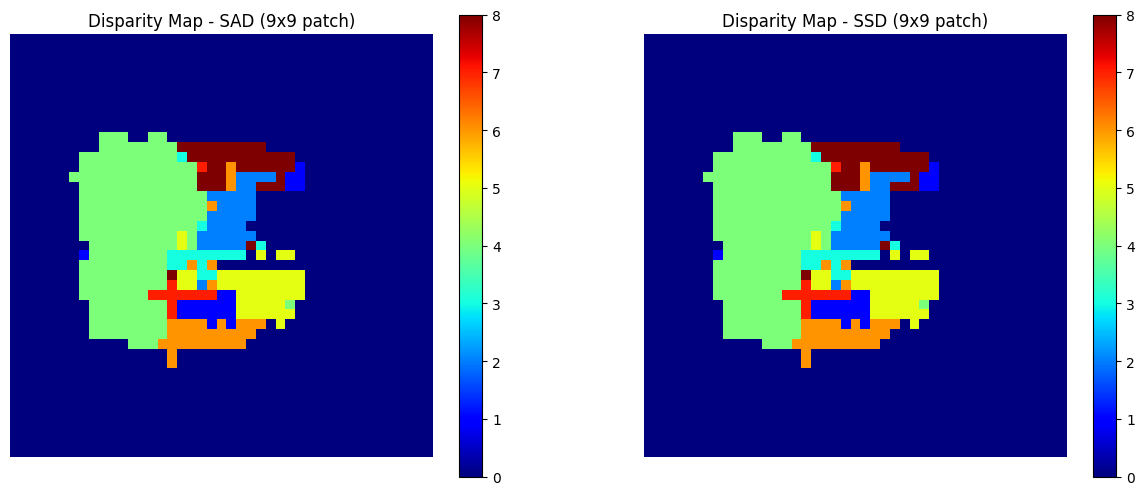

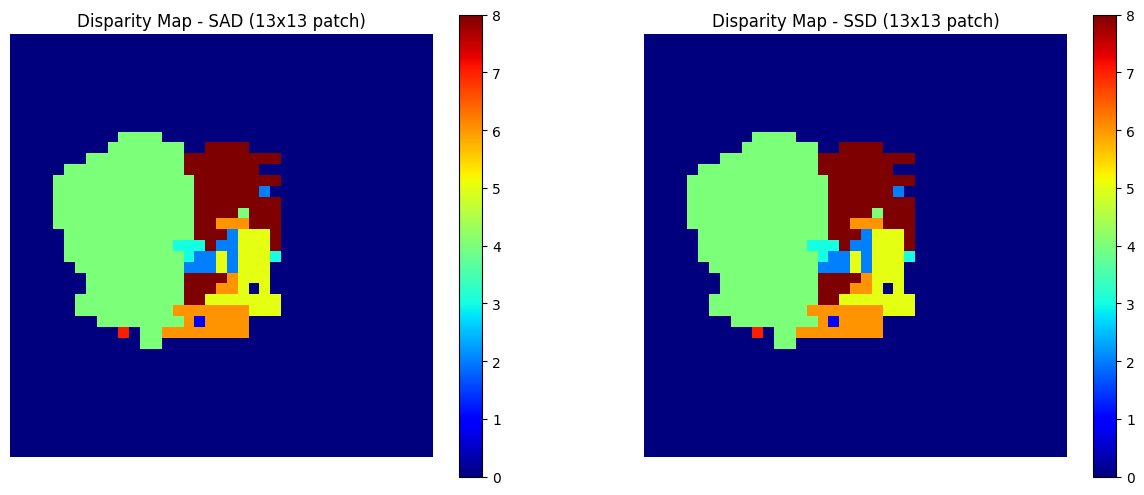

In [71]:
stereo_helper_fn(im_left, im_right, block_size = [3,5,9,13], max_search_bound=8)

### Reflection Question 3:
What is the effect of increasing the block size? Explain the reasoning behind it.  
**Answer:** Larger blocks cover more pixels, so the blocks come closer to the overall average. This means that mismatches will be reduced. and blocks will match more easily.

### Reflection Question 4:
Observe the random dot stereogram disparity map. Why does the left edge show poor results?  
**Answer:** The window that matches patches goes over the edge. The values inputted are 0s or something incorrect, making the edge show poorly.

## Error Profile Analysis

In this section, you will analyze the **similarity error profile** between patches to understand how matching quality varies with horizontal shifts.

You need to find **two examples** that display:
- A **convex error profile** (smooth, single minimum)
- A **non-convex error profile** (multiple minima)

For reference, here are example plots:

<img src="figures/convex_sample.png" width="350"/>  

**Convex Profile**

<img src="figures/non_convex_sample.png" width="350"/>  

**Non-Convex Profile**

Before computing the full disparity map, analyze the similarity error between patches in both cases.
Find regions in the image that exhibit a close-to-convex profile and another that exhibits a highly non-convex profile.

In [72]:
# Load and downsample Adirondack stereo pair
base_path = '../data/adirondack/'
im_left = PIL_resize(load_image(base_path + 'im_left.png'), (0.1, 0.1))
im_right = PIL_resize(load_image(base_path + 'im_right.png'), (0.1, 0.1))

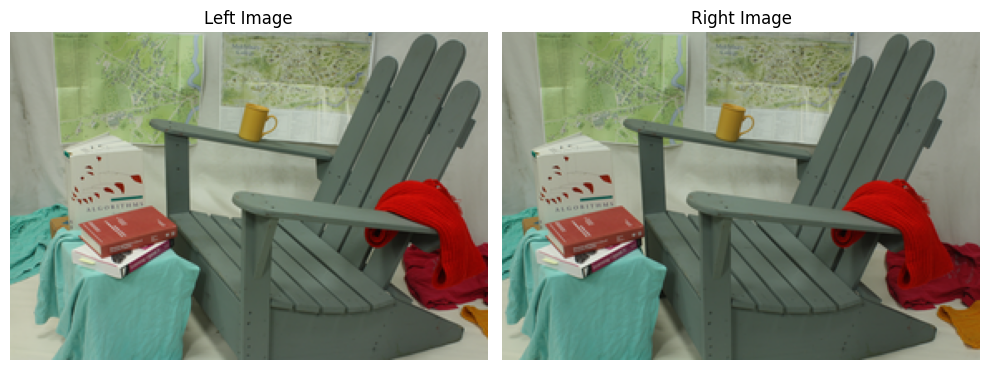

In [73]:
# Visualize left and right images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

ax1.imshow(im_left)
ax1.set_title('Left Image')
ax1.axis('off')

ax2.imshow(im_right)
ax2.set_title('Right Image')
ax2.axis('off')

plt.tight_layout()
plt.show()

## Convex error profile

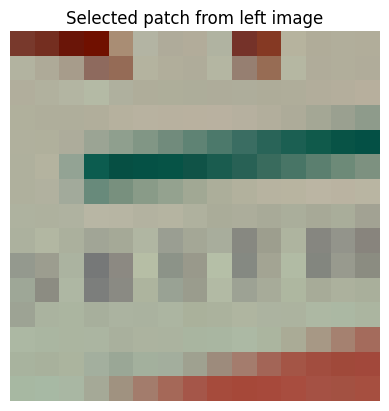

In [74]:
# Extract a patch of interest from the left image
patch_size = 15
#x_idx=1169, y_idx=708
#x_idx=960, y_idx=579

x_idx, y_idx = (96, 58)  # TODO: adjust coordinates based on image texture
patch_left_img = torch.tensor(im_left[x_idx:x_idx+patch_size, y_idx:y_idx+patch_size, :])

plt.imshow(patch_left_img)
plt.title("Selected patch from left image")
plt.axis('off')
plt.show()

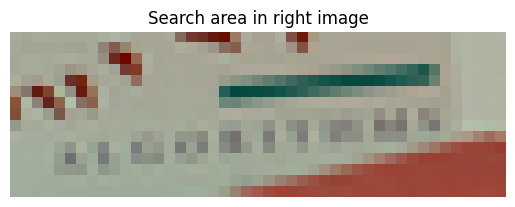

In [75]:
# Define the search area in the right image
max_search_bound = 30  # might need adjustment based on your (x_idx, y_idx)

search_area_right_img = torch.tensor(
    im_right[x_idx:x_idx+patch_size, max(0, y_idx-max_search_bound):y_idx+patch_size, :]
)

plt.imshow(search_area_right_img)
plt.title("Search area in right image")
plt.axis('off')
plt.show()

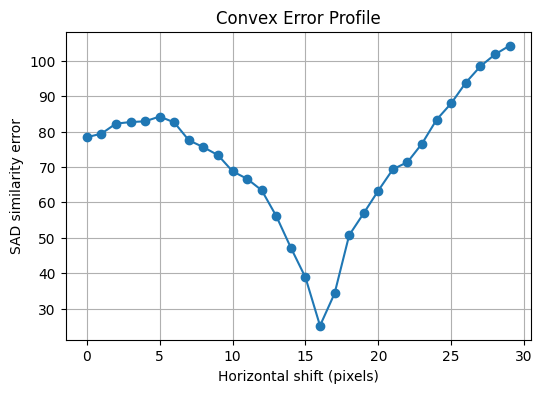

In [76]:
# Compute similarity (SAD) between patch and all horizontal shifts
similarity_vals = np.array([
    sad_similarity_measure(
        patch_left_img,
        search_area_right_img[:, h_idx:h_idx+patch_size, :]
    ).item()
    for h_idx in range(search_area_right_img.shape[1] - patch_size)
])

# Plot convex error profile
plt.figure(figsize=(6, 4))
plt.plot(similarity_vals, '-o')
plt.title("Convex Error Profile")
plt.xlabel("Horizontal shift (pixels)")
plt.ylabel("SAD similarity error")
plt.grid(True)
plt.show()

### Reflection Question 5:
Convex Error Profile: Can you generalize the type of regions that generate a convex error profile?    
**Answer:** A single minimum is a nice convex profile, which is what we see here. Regions would include edges and corners where this profile can be clearly seen. Also in contrast regions. 

## Non-Convex error profile

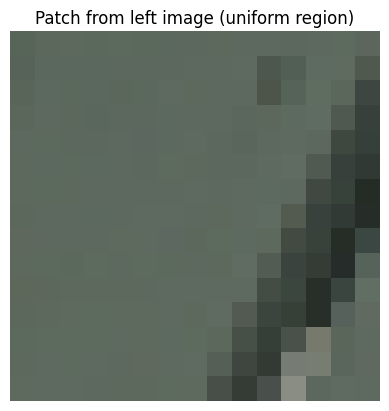

In [77]:
# Extract patch from a uniform region (for non-convex behavior)
patch_size = 15
x_idx, y_idx = (50, 240)  # # TODO: adjust coordinates based on image texture
patch_left_img = torch.tensor(im_left[x_idx:x_idx+patch_size, y_idx:y_idx+patch_size, :])

plt.imshow(patch_left_img)
plt.title("Patch from left image (uniform region)")
plt.axis('off')
plt.show()

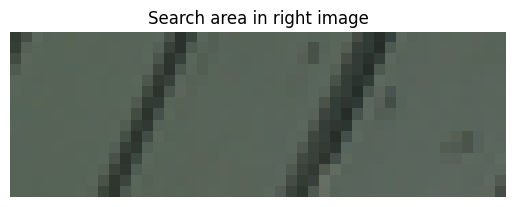

In [78]:
# Define search area in the right image
max_search_bound = 30 # might need adjustment based on your (x_idx, y_idx)

search_area_right_img = torch.tensor(
    im_right[x_idx:x_idx+patch_size, max(0, y_idx-max_search_bound):y_idx+patch_size, :]
)

plt.imshow(search_area_right_img)
plt.title("Search area in right image")
plt.axis('off')
plt.show()

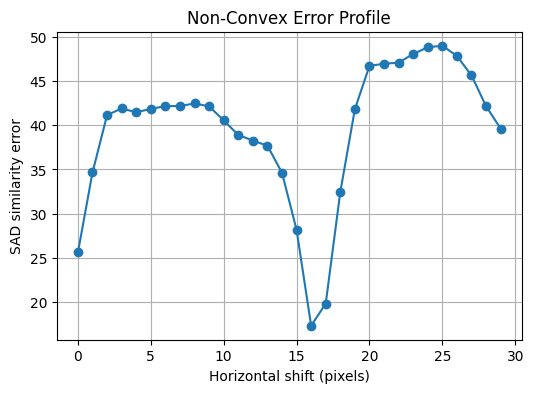

In [79]:
# Compute similarity (SAD) across horizontal shifts for non-convex region
similarity_vals = np.array([
    sad_similarity_measure(
        patch_left_img,
        search_area_right_img[:, h_idx:h_idx+patch_size, :]
    ).item()
    for h_idx in range(search_area_right_img.shape[1] - patch_size)
])

plt.figure(figsize=(6, 4))
plt.plot(similarity_vals, '-o')
plt.title("Non-Convex Error Profile")
plt.xlabel("Horizontal shift (pixels)")
plt.ylabel("SAD similarity error")
plt.grid(True)
plt.show()

## Reflection Question 6:
Non-Convex Error Profile: Can you generalize the type of regions that generate a non-convex error profile?    
**Answer:** Non-convex means having multiple local minima. This can happen with ambiguous patch matching. This can happen in regions with repetitive patterns, or a more uniform look.

# Real life stereo images

## Example 1

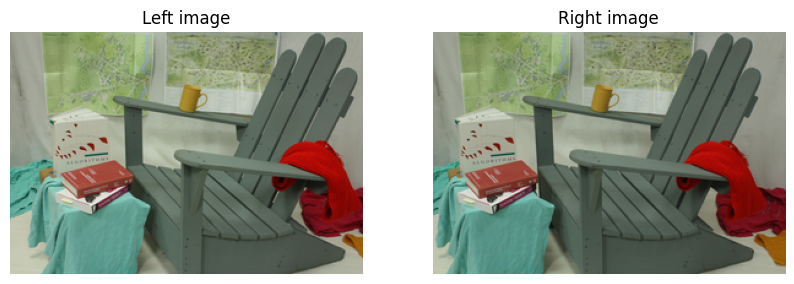

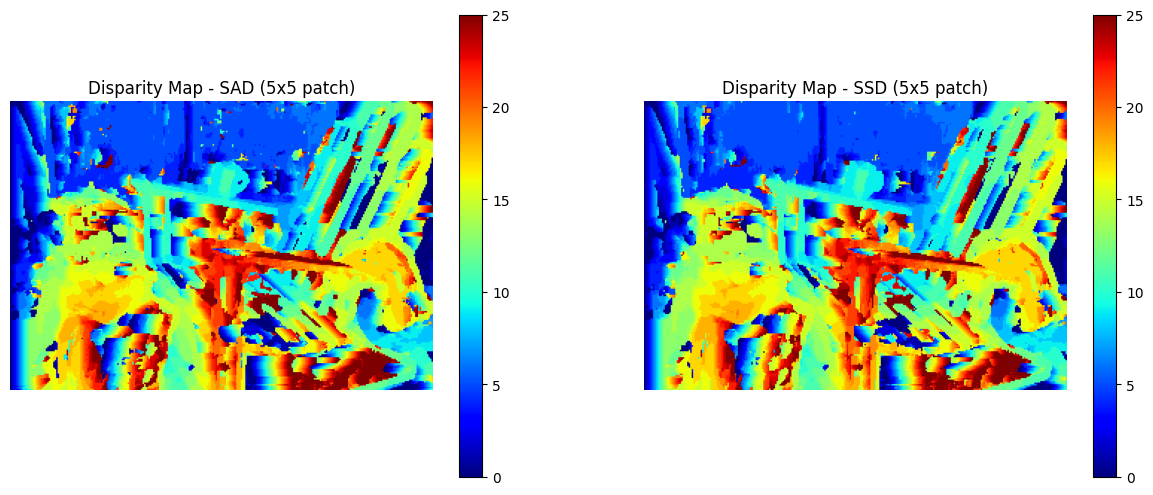

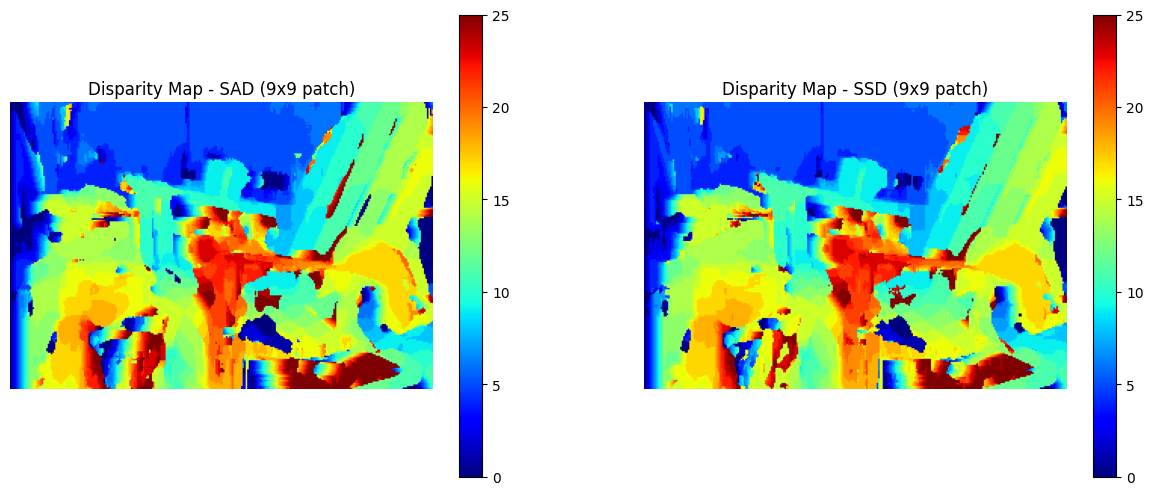

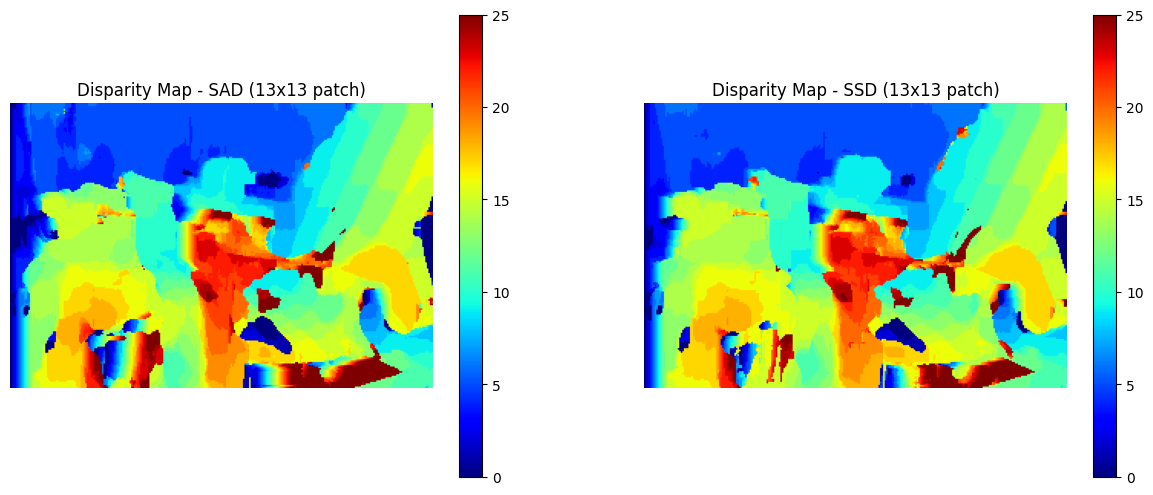

In [80]:
# Visualize disparity maps for real stereo pair (Adirondack)
# Try varying block_size and max_search_bound for best results
stereo_helper_fn(
    torch.tensor(im_left),
    torch.tensor(im_right),
    block_size=[5, 9, 13],
    max_search_bound=25
)

### Reflection Question 7:
Which patch size gives the clearest depth representation? Why?  
**Answer:** For this image, an 8x8 patch size worked well. It was not too small to get lost indetails and not too big to blur the image.

### Reflection Question 8:
Why does the backrest of the chair appear blocky in the disparity map?  
**Answer:** It has a repetitive pattern and there is no large color variation. So, it turns blocky.

## Set 2

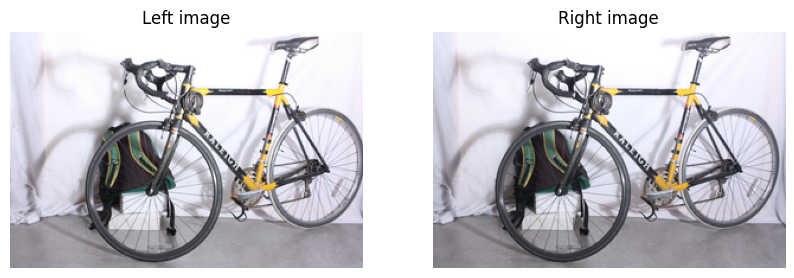

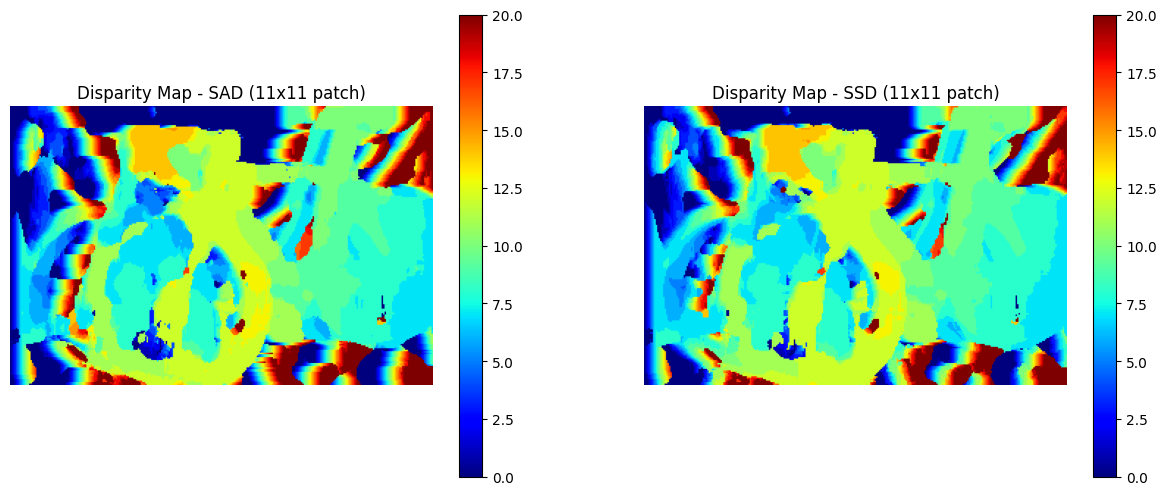

In [81]:
# =========================================
# Set 2: Bicycle Scene
# =========================================
base_path = '../data/bicycle/'

# Load and downscale to 10% size for faster processing
im_left = PIL_resize(load_image(base_path + 'im_left.png'), (0.1, 0.1))
im_right = PIL_resize(load_image(base_path + 'im_right.png'), (0.1, 0.1))

# Compute and visualize disparity maps
stereo_helper_fn(
    torch.tensor(im_left),
    torch.tensor(im_right),
    block_size=[11],       # Experiment: try 7, 9, 11, 13
    max_search_bound=20
)

## Set 3

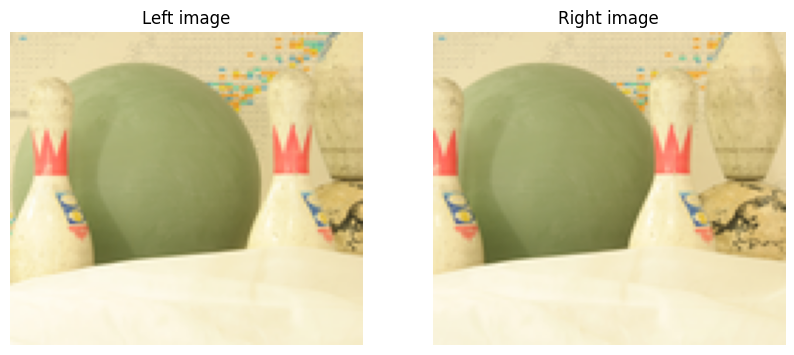

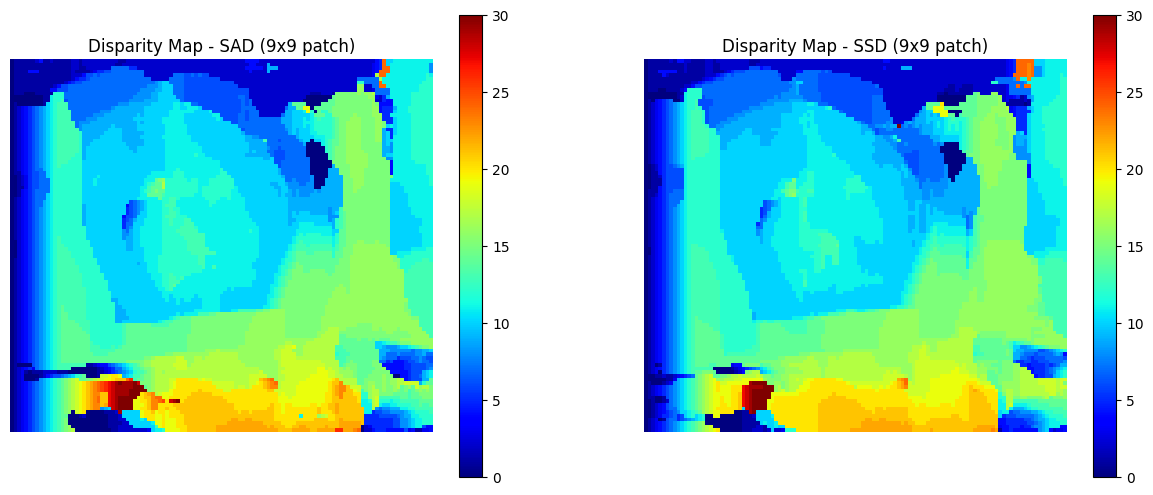

In [82]:
# =========================================
# Set 3: Bowling Scene
# =========================================
base_path = '../data/bowling/'

# Load and downscale to 20% size
im_left = PIL_resize(load_image(base_path + 'im_left.png'), (0.2, 0.2))
im_right = PIL_resize(load_image(base_path + 'im_right.png'), (0.2, 0.2))

# Compute and visualize disparity maps
stereo_helper_fn(
    torch.tensor(im_left),
    torch.tensor(im_right),
    block_size=[9],
    max_search_bound=30
)

### Reflection Question 9:
Bowling Scene (Set 3): Observe the head of the right-side bowling pin. What do you notice in the disparity map?  
What visual property might explain this behavior?  
**Answer:** The surface is noisy, with shiny parts which was seen as a brightness changes.

## Set 4

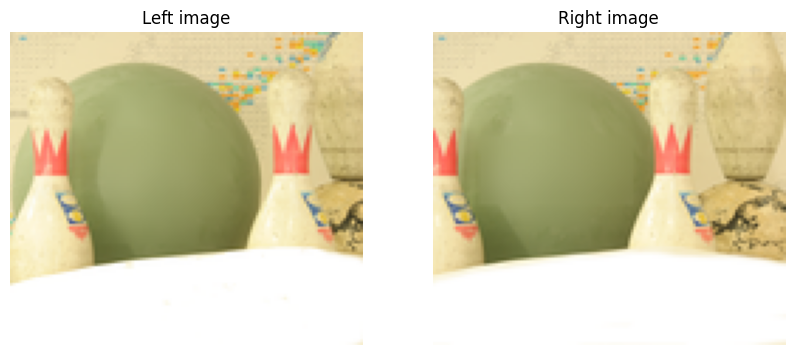

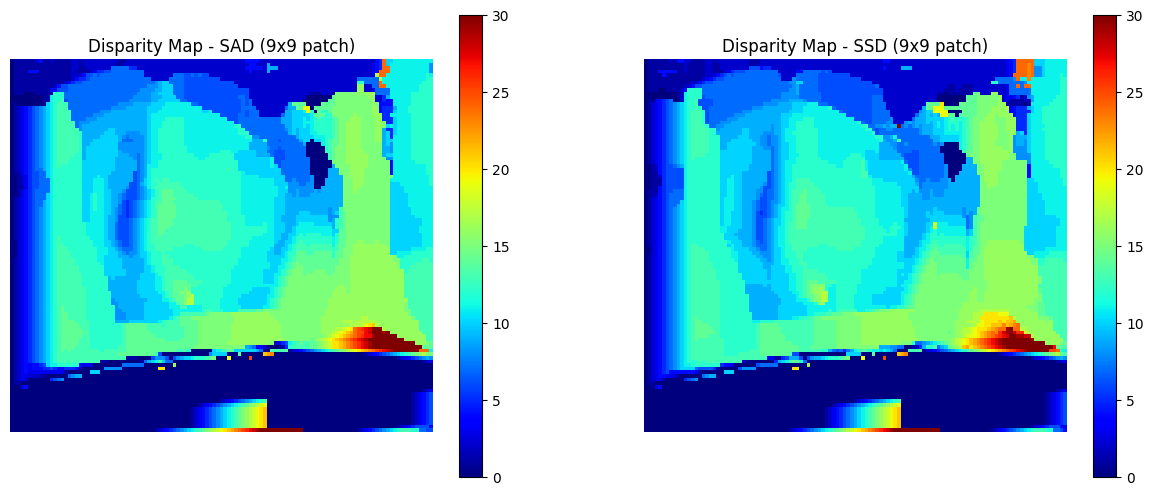

In [83]:
# =========================================
# Set 4: Bowling (Manipulated Scene)
# =========================================
base_path = '../data/bowling2/'

# Load and resize to 20% scale
im_left = PIL_resize(load_image(base_path + 'im_left.png'), (0.2, 0.2))
im_right = PIL_resize(load_image(base_path + 'im_right.png'), (0.2, 0.2))

# Visualize disparity map
stereo_helper_fn(
    torch.tensor(im_left),
    torch.tensor(im_right),
    block_size=[9],
    max_search_bound=30
)

### Reflection Question 10:
Manipulated Bowling Scene (Set 4): Why does the disparity drop to zero at the bottom of the image and around the green bowling ball?  
**Answer:** The bottom and the green ball were seen as similar/identical. There was therefore no visible shift and it found no disparity.

## Set 5

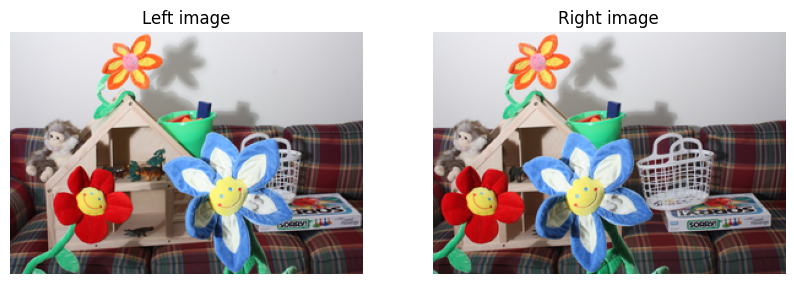

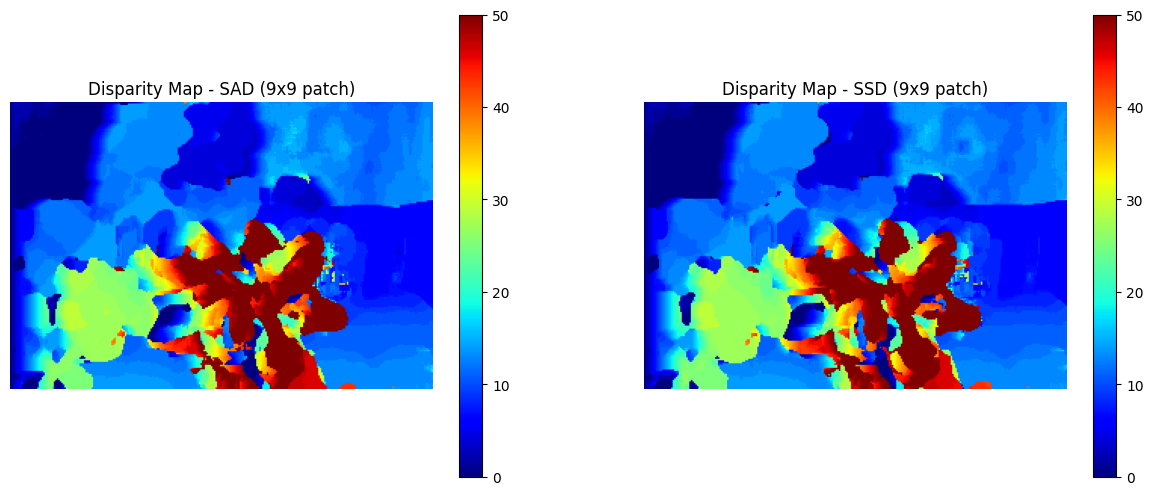

In [84]:
# =========================================
# Set 5: Flowers Scene
# =========================================
base_path = '../data/flowers/'

# Load and downscale to 10% for faster computation
im_left = PIL_resize(load_image(base_path + 'im_left.png'), (0.10, 0.10))
im_right = PIL_resize(load_image(base_path + 'im_right.png'), (0.10, 0.10))

# Compute and visualize disparity maps
stereo_helper_fn(
    torch.tensor(im_left),
    torch.tensor(im_right),
    block_size=[9],
    max_search_bound=50
)

**Observations**: (these observations do not go in the report. These are for your understanding).

(These are not part of the report but are meant to guide your interpretation.)

1.	Notice the difference in disparity between the flower at the back and its shadow on the wall.

2.	Identify the zero-disparity region at the center of the house structure.

3.	Observe how smooth the disparity is across the couch — what does this tell you about texture and surface uniformity?

## Set 6

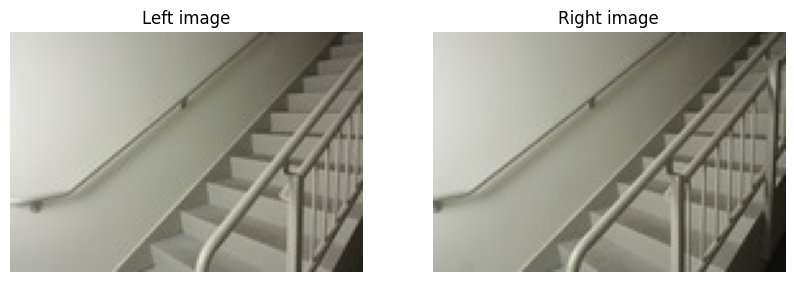

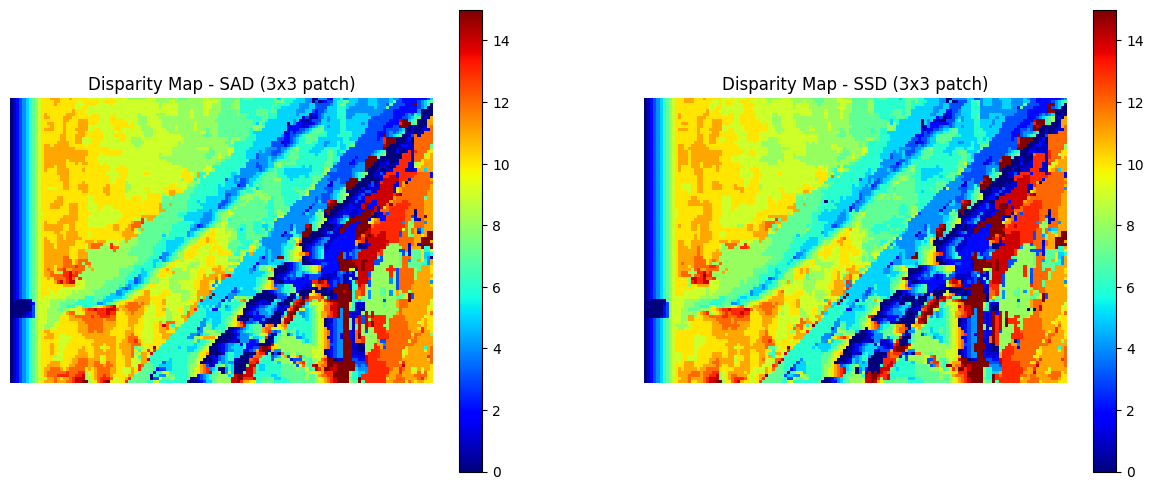

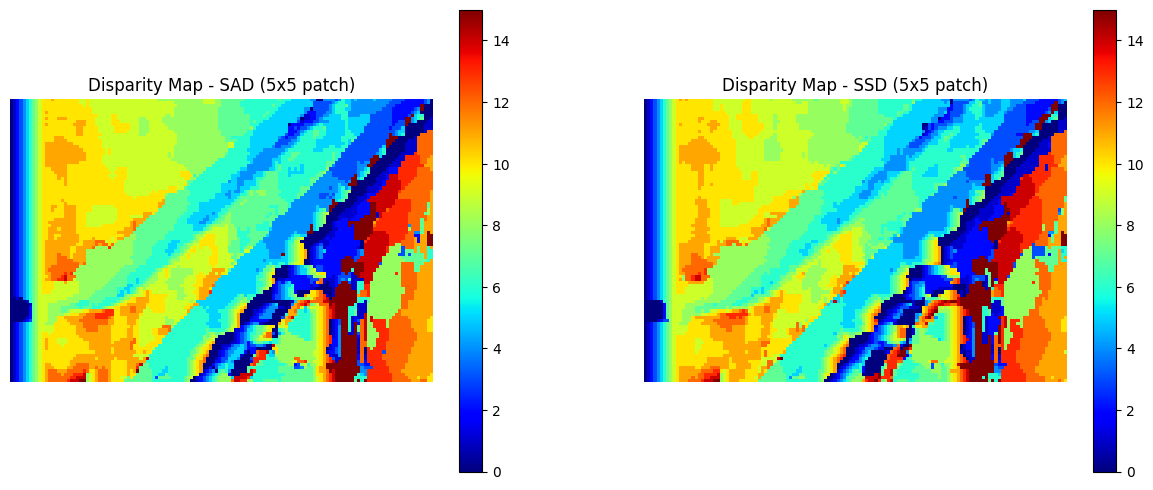

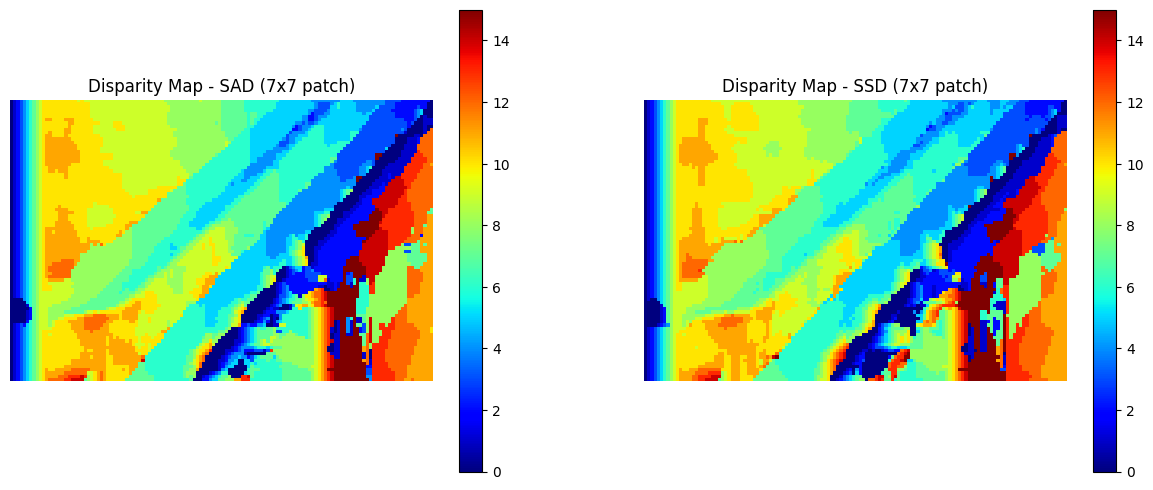

In [85]:
# =========================================
# Set 6: Stairs Scene
# =========================================
base_path = '../data/stairs/'

# Load and keep full resolution (1x scale)
im_left = PIL_resize(load_image(base_path + 'im_left.jpg'), (1, 1))
im_right = PIL_resize(load_image(base_path + 'im_right.jpg'), (1, 1))

# Compute and visualize disparity maps
stereo_helper_fn(
    torch.tensor(im_left),
    torch.tensor(im_right),
    block_size=[3, 5, 7],
    max_search_bound=15
)

### Reflection Question 11:
Why are we able to see a gradual shift in disparity values along the wall?  
**Answer:** We see a shift in disparity as the shadow/darkness increases along the wall. The depth is also increasing, and the disparity is the inverse of that, so it decreases.

### Reflection Question 12: 
What is the effect of block size on your ability to see the stair-like structure in the disparity map?  
**Answer:** Larger blocks make the stairs blur together and smaller blocks the stair structure is more visible, as they highlight finer features.

# Smoothing

One issue with the results from is that they aren't very smooth. Pixels next to each other on the same surface can have vastly different disparities, making the results look very noisy and patchy in some areas. Intuitively, pixels next to each other should have a smooth transition in disparity(unless at an object boundary or occlusion).
In this section, we try to improve our results. One way of doing this is through the use of a smoothing constraint. The smoothing method we use is called Semi-Global Matching(SGM) or Semi-Global Block Matching. Before, we picked the disparity for a pixel based on the minimum matching cost of the block using some metric(SSD or SAD). The basic idea of SGM is to penalize pixels with a disparity that's very different than their neighbors by adding a penalty term on top of the matching cost term. SGM tries to minimize the global(over the entire image) energy function
\begin{equation*}
E(D) \leq \sum_{p} (C(p, D_p) + \sum_{q} PT(|D_p - D_q|))
\end{equation*}
C(p,D_p) is the matching cost for a pixel with disparity D_p, q is a neighboring pixel, and PT is some penalty function penalizing the difference in disparities.
You can read more about how this method works and is optimized here:
https://elib.dlr.de/73119/1/180Hirschmueller.pdf
and
https://pdfs.semanticscholar.org/bcd8/4d8bd864ff903e3fe5b91bed3f2eedacc324.pdf

Before we implement the smoothing algorithm, we need to implement a function which computes the **cost volume**. We have already written code to compute disparity map. We will extend that code to compute the cost volume. Instead of taking the argmin of the similarity error profile, we will store the tensor of error profile at each pixel location along the third dimension.

If we have an input image of dimension (H,W,C) and max search bound of D, the cost_volume will be a tensor of dimension (H,W,D). The cost volumne at (i,j) pixel is the error profile obtained for the patch in the left image centered at (i,j).

Implement this part as function ```calculate_cost_volume``` in ```disparity_map.py```. Feel free to reuse any code you have written till now.

In [86]:
from unit_tests.test_disparity_map import (
  test_calculate_cost_volume
)

print('Testing for calculate_cost_volume', verify(test_calculate_cost_volume))

Testing for calculate_cost_volume "Correct"


In [88]:
%pip install scipy


  Using cached scipy-1.16.3-cp313-cp313-win_amd64.whl.metadata (60 kB)
Using cached scipy-1.16.3-cp313-cp313-win_amd64.whl (38.5 MB)
Note: you may need to restart the kernel to use updated packages.



Starting cost computation...

Starting aggregation computation...
	Processing paths east and west...	(done in 2.67 s)
	Processing paths south-east and north-west...	(done in 3.53 s)
	Processing paths south and north...	(done in 2.90 s)
	Processing paths south-west and north-east...	(done in 3.63 s)

Selecting best disparities...

Done


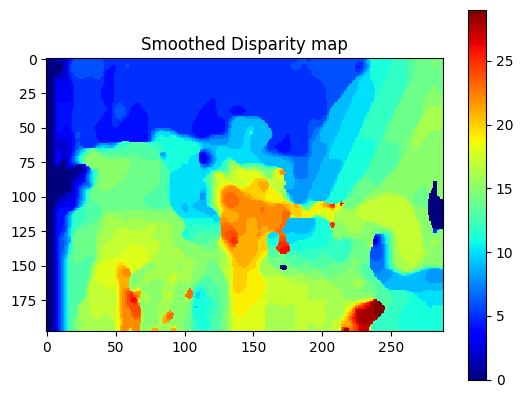

In [89]:
# Load the image
from semiglobalmatching.sgm import sgm
from scipy import ndimage
from proj4_code.similarity_measures import sad_similarity_measure, ssd_similarity_measure

#you can change the path to try other pairs, but you may need to fix the scaling per pair
base_path = '../data/adirondack/'
im_left = PIL_resize(load_image(base_path + 'im_left.png'), (0.10, 0.10))
im_right = PIL_resize(load_image(base_path + 'im_right.png'), (0.10, 0.10))

#calculates the disparity map with SGM, the last argument is max disparity to consider
disparity_map = sgm(im_left,im_right, "result", 30, sad_similarity_measure, 9)
result = ndimage.median_filter(disparity_map, size=5)
plt.figure()
plt.imshow(result, cmap='jet', interpolation='nearest')
plt.title('Smoothed Disparity map')
plt.colorbar()
plt.show()

### Reflection Question 13:
Compare SGM (smoothing) result vs disparity map of the chair image without smoothing.  
**Answer:** When it is smoothened, the random noise reduces. It also affects some of the edges but they are still visible. 

### Reflection Question 14:
On what regions of the image does smoothing perform better, and why?  
**Answer:** Smoothing performs better on the parts of the image which are slow changing because most of the changes they hold are actually just noise which shoudl be removed.

### Reflection Question 15:
On what regions of the image does smoothing perform worse, and why?  
**Answer:** It does worse near sharp edges and bounderies as it will blur the sharpness and we will have a less sharp edge to work with, which can mean less accurate edge detection.

### Reflection Question 16:
Would smoothing still work for images with both horizontal and vertical shift? Explain why or why not.  
**Answer:** It assumes that the shift is horizonatl, so it will not work as it is. With changes of handlign 2D, it might be able to account for both horizontal and vertical shifts.

### Reflection Question 17: Extra Credit
Try the smoothing method with your own image pair.  
If good results, explain why your pair is “easy.”  
If bad results, explain why your pair is “hard.”  
**Answer:** Insert your own left and right images here along with text explanation here